In [31]:
# LSTM for international airline passengers problem with regression framing
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import RepeatVector
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)
    
# fix random seed for reproducibility
numpy.random.seed(7)

# load the dataset
dataframe = read_csv('international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


In [6]:
# create and fit the LSTM network
encoder_decoder = Sequential()
encoder_decoder.add(LSTM(128, input_shape=(1, look_back), return_sequences=True))
encoder_decoder.add(LSTM(32, input_shape=(1, look_back)))
encoder_decoder.add(RepeatVector(3))
encoder_decoder.add(LSTM(128, input_shape=(1, look_back), return_sequences=True))
encoder_decoder.add(LSTM(32, input_shape=(1, look_back)))
encoder_decoder.add(Dense(1))
encoder_decoder.compile(loss='mean_squared_error', optimizer='adam')
encoder_decoder.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)

In [32]:
def initialize_encoder():
    input1 = Input((1, look_back))
    x = LSTM(128, input_shape=(1, look_back), return_sequences=True)(input1)
    x, state_h, state_c = LSTM(32, input_shape=(1, look_back), return_state=True)(x)
    encoder = Model(inputs=input1, outputs=[x, state_h, state_c])
    encoder.compile(loss='mean_squared_error', optimizer='adam')
    return encoder

def set_encoder_weight(encoder, model):
    encoder.layers[1].set_weights(model.layers[0].get_weights())    
    encoder.layers[2].set_weights(model.layers[1].get_weights())
    return encoder

def fit_bnn(trainX, trainY):
    input1 = Input((32,))
    x = Dense(128, activation="tanh")(input1)
    x = Dropout(0.05)(x, training=True)
    x = Dense(64, activation="tanh")(x)
    x = Dropout(0.05)(x, training=True)
    x = Dense(16, activation="tanh")(x)
    x = Dropout(0.05)(x, training=True)
    x = Dense(1)(x)
    bnn = Model(inputs=[input1], outputs=[x])
    bnn.compile(loss='mean_squared_error', optimizer='adam')
    # fit network
    bnn.fit(trainX, trainY, epochs=1000, verbose=0, shuffle=False)
    return bnn

In [8]:
# extract embedding
encoder = initialize_encoder()
encoder = set_encoder_weight(encoder, encoder_decoder)
output, state_h, train_state_c = encoder.predict(trainX)
output, state_h, test_state_c = encoder.predict(testX)

# state_c = numpy.reshape(state_c, (state_c.shape[0], 1, state_c.shape[1]))
# print state_c.shape

In [33]:
# fit bnn
bnn = fit_bnn(train_state_c, trainY)
print bnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               4224      
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 16)                1040      
_________________________________________________________________
dropout_6 (Dropout)          (None, 16)                0         
__________

Train Score: 23.72 RMSE
Test Score: 60.95 RMSE
[63.566948]
[63.249172]


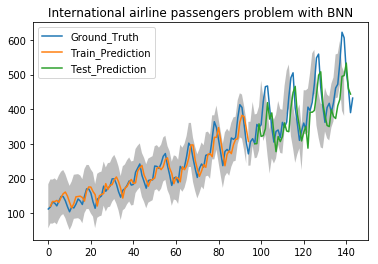

In [35]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

trainPredict_list, testPredict_list = list(), list()
for i in range(1000):
    # make predictions
    trainPredict = bnn.predict(train_state_c)
    testPredict = bnn.predict(test_state_c)

    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    testPredict = scaler.inverse_transform(testPredict)

trainPredict_list.append(trainPredict)
testPredict_list.append(testPredict)

trainPredict = numpy.mean(trainPredict_list,axis=0)
testPredict = numpy.mean(testPredict_list,axis=0)
train_up = numpy.add(trainPredict, numpy.std(trainPredict)).flatten()
train_down = numpy.subtract(trainPredict,  numpy.std(trainPredict)).flatten()
test_up = numpy.add(testPredict, numpy.std(testPredict)).flatten()
test_down = numpy.subtract(testPredict, numpy.std(testPredict)).flatten()

trainY = scaler.inverse_transform([trainY])
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# standard deviation
print numpy.std(trainPredict,axis=0)
print numpy.std(testPredict,axis=0)

# plot baseline and predictions
plt.title("International airline passengers problem with BNN")
plt.plot(scaler.inverse_transform(dataset), label="Ground_Truth")
plt.plot(trainPredictPlot, label="Train_Prediction")
plt.fill_between([x for x in range(94)], train_up, train_down, alpha=0.5, facecolor='tab:gray')
plt.plot(testPredictPlot, label="Test_Prediction")
plt.fill_between([x for x in range(94,140)], test_up, test_down, alpha=0.5, facecolor='tab:gray')
plt.legend()
plt.savefig("BNN", dpi=1000)
plt.show()